<a href="https://colab.research.google.com/github/danielperebinos/Deep-Learning/blob/main/Sigmoid_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/Datasets/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip lorencpetr/chatbot-intent-classification

  0% 0.00/11.5k [00:00<?, ?B/s]
100% 11.5k/11.5k [00:00<00:00, 8.08MB/s]


In [ ]:
import json

import torch
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torch import nn
from torchtext.vocab import GloVe
torch.manual_seed(42)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import copy

In [ ]:
with open('intent-corpus-basic.json') as f:
  DATA = json.load(f)['sentences']

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
MAX_LENGTH = 0

df_train, df_test = pd.DataFrame(), pd.DataFrame()
train_text, test_text = [], []
train_intent, test_intent = [], []

for sentence in DATA:
  tokens = tokenizer(sentence['text'])
  MAX_LENGTH = max(MAX_LENGTH, len(tokens))

  if not sentence['training']:
    train_text.append(tokens)
    train_intent.append(sentence['intent'])
  else:
    test_text.append(tokens)
    test_intent.append(sentence['intent'])

df_train['text'] = train_text
df_train['intent'] = train_intent

df_test['text'] = test_text
df_test['intent'] = test_intent

In [ ]:
df_train

,text,intent
0,[yes],yesNode
1,[yea],yesNode
2,[ok],yesNode
3,"[oh, yes]",yesNode
4,[yea],yesNode
...,...,...
984,"[are, you, asleep]",stillThere
985,"[have, you, turned, off]",stillThere
986,"[have, you, stopped]",stillThere
987,"[did, you, stop]",stillThere


In [ ]:
df_train.text

0                         [yes]
1                         [yea]
2                          [ok]
3                     [oh, yes]
4                         [yea]
                 ...           
984          [are, you, asleep]
985    [have, you, turned, off]
986        [have, you, stopped]
987            [did, you, stop]
988            [did, you, quit]
Name: text, Length: 989, dtype: object

In [ ]:
intent2label = {
    intent: label
    for label, intent in enumerate(df_train['intent'].unique())
}

df_train['label'] = df_train['intent'].apply(lambda x: intent2label[x])
df_test['label'] = df_test['intent'].apply(lambda x: intent2label[x])

In [ ]:
df_train

,text,intent,label
0,[yes],yesNode,0
1,[yea],yesNode,0
2,[ok],yesNode,0
3,"[oh, yes]",yesNode,0
4,[yea],yesNode,0
...,...,...,...
984,"[are, you, asleep]",stillThere,13
985,"[have, you, turned, off]",stillThere,13
986,"[have, you, stopped]",stillThere,13
987,"[did, you, stop]",stillThere,13


In [ ]:
glove = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:13<00:00, 28971.22it/s]


In [ ]:
class Dataset:
  def __init__(self, df, max_length = MAX_LENGTH):
    self.df = df
    self.max_length = max_length
  
  def __len__(self):
    return self.df.shape[0]
  
  def __getitem__(self, idx):
    arr = self.df.loc[idx, 'text']
    arr = arr + ['<PAD>'] * (self.max_length - len(arr))
    return (
        glove.get_vecs_by_tokens(arr),
        self.df.loc[idx,'label']
    )

In [ ]:
train_set = Dataset(df_train)
test_set = Dataset(df_test)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle = False)

In [ ]:
class LSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True, dropout=0.2):
    super().__init__()

    self.lstm = nn.LSTM(embedding_dim,
                        hidden_dim,
                        num_layers = n_layers,
                        bidirectional = bidirectional,
                        dropout = dropout,
                        batch_first = True
                        )
    
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

  def forward(self, embeds):
     packed_output, (hidden, cell) = self.lstm(embeds)

     hidden = torch.cat((hidden[-2, :, :], hidden[-1,:,:]), dim=1)

     dense_outputs = self.fc(hidden)

     return dense_outputs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = LSTM(50, 32, len(intent2label), 2).to(device)

In [ ]:
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def training_loop(n_epochs, model, optim, loss_fn, train_loader, test_loader):
  train_accuracy = torch.zeros(n_epochs)
  test_accuracy = torch.zeros(n_epochs)

  for epoch in range(n_epochs):
    model.train()
    for examples, labels in train_loader:
      examples = examples.to(device)
      labels = labels.to(device)

      outputs = model(examples)
      loss = loss_fn(outputs, labels)

      optim.zero_grad()
      loss.backward()
      optim.step()


    model.eval()
    for loader, accuracy in [
          (train_loader, train_accuracy),
          (test_loader, test_accuracy)
    ]:

      correct = 0
      total = 0

      with torch.no_grad():
        for examples, labels in loader:
          examples = examples.to(device)
          labels = labels.to(device)

          outputs = model(examples)
          _, predicted = torch.max(outputs, dim=1)

          total += labels.shape[0]
          correct += int((predicted == labels).sum())
      
      accuracy[epoch] = correct/total
  
    best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1]).item()
    if best_test_accuracy:
      best_model = copy.deepcopy(model.state_dict())
  

    print(f'Epoch {epoch + 1}',
          f'Train Accuracy: {train_accuracy[epoch]}',
          f'Test Accuracy: {test_accuracy[epoch]}')

  plt.figure(dpi = 150)
  plt.xlabel('number of Epochs')
  plt.ylabel('Accuracy')
  plt.plot(range(1, n_epochs+1), train_accuracy)
  plt.plot(range(1, n_epochs+1), test_accuracy)
  plt.legend(['Train_accuracy', 'Test_accuracy'])
  plt.grid()
  plt.show()

  return best_model

Epoch 1 Train Accuracy: 0.4266936182975769 Test Accuracy: 0.4272727370262146
Epoch 2 Train Accuracy: 0.4266936182975769 Test Accuracy: 0.4272727370262146
Epoch 3 Train Accuracy: 0.5672396421432495 Test Accuracy: 0.5575757622718811
Epoch 4 Train Accuracy: 0.6885743141174316 Test Accuracy: 0.6636363863945007
Epoch 5 Train Accuracy: 0.7522750496864319 Test Accuracy: 0.7151514887809753
Epoch 6 Train Accuracy: 0.7745197415351868 Test Accuracy: 0.739393949508667
Epoch 7 Train Accuracy: 0.7846309542655945 Test Accuracy: 0.7424242496490479
Epoch 8 Train Accuracy: 0.8038422465324402 Test Accuracy: 0.7696969509124756
Epoch 9 Train Accuracy: 0.8382204174995422 Test Accuracy: 0.7848485112190247
Epoch 10 Train Accuracy: 0.8382204174995422 Test Accuracy: 0.7969697117805481
Epoch 11 Train Accuracy: 0.8452982902526855 Test Accuracy: 0.800000011920929
Epoch 12 Train Accuracy: 0.8614762425422668 Test Accuracy: 0.821212112903595
Epoch 13 Train Accuracy: 0.8796764612197876 Test Accuracy: 0.821212112903595

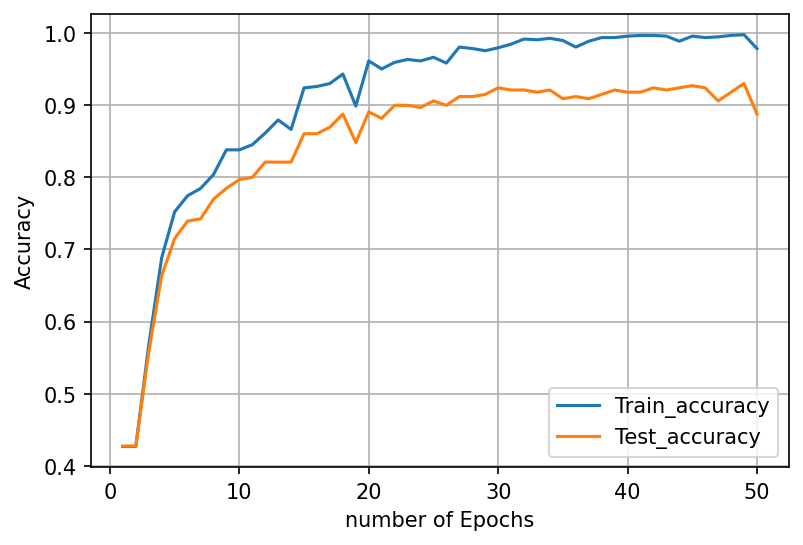

In [ ]:
best_model = training_loop(50, model, optim, loss_fn, train_loader, test_loader)

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_test = torch.zeros(len(df_test))
y_pred = torch.zeros(len(df_test))
low = 0

model.eval()
with torch.no_grad():
  for examples, labels in test_loader:
    examples = examples.to(device)
    labels = labels.to(device)

    outputs = model(examples)
    _, predicted = torch.max(outputs, dim=1)

    high = low + labels.shape[0]
    y_test[low : high] = labels
    y_pred[low : high] = predicted
    low = high

    total += labels.shape[0]
    correct += int((predicted == labels).sum())

accuracy = correct / total
accuracy

0.9303030303030303

Text(0.5, 32.08333333333333, 'Predicted Label')

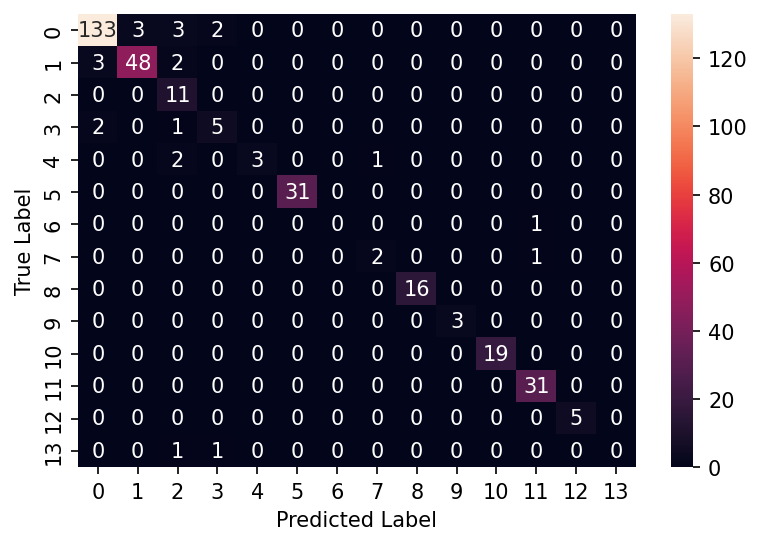

In [ ]:
plt.figure(dpi = 150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [ ]:
intent2label

{'Repeat': 4,
 'gamesCounter': 9,
 'listOfGames': 8,
 'maybeNode': 2,
 'noNode': 1,
 'playOtherGame': 5,
 'stillThere': 13,
 'stop': 3,
 'timesPlayed': 12,
 'totalStop': 6,
 'volumeDown': 11,
 'volumeUp': 10,
 'wait': 7,
 'yesNode': 0}